In [1]:
import backproject
import id_generation
import numpy as np
import glob
import cv2
import torch
import matplotlib.pyplot as plt

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
path_to_traj = "/home/koerner/Project/nice-slam/Datasets/generated/room0/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)

In [4]:
directory = "/home/koerner/Project/nice-slam/Datasets/generated/room0/results"
every_frame= 5

In [5]:
def readDepth(filepath):
    depth=cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    return depth_data

In [6]:

# color_paths = sorted(glob.glob('/home/julius/Project/nice-slam/Datasets/Replica/room0/results/frame*.jpg'))
depth_paths = sorted(
    glob.glob(
        "/home/koerner/Project/nice-slam/Datasets/generated/room0/results/depth*.png"
    )
)
frame_paths=sorted(glob.glob("/home/koerner/Project/nice-slam/Datasets/generated/room0/results/frame*.jpg"))

seg_paths = sorted(
    glob.glob(
        "/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic*.npy"
    )
)
print(len(seg_paths))

41


In [7]:
K = np.array([[600, 0.0, 599.5], [0.0, 600, 339.5], [0.0, 0.0, 1.0]])

In [8]:
first = np.load(
    "/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic000000.npy"
)
segmentations = []
segmentations.append(first)
np.unique(first)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85], dtype=int32)

In [9]:
id_counter = len(np.unique(first))
id_counter

86

In [10]:
#np.save(store_path + "/seg000000.npy", first)

In [11]:
#sam Predict
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from id_generation import createReverseMapping
from backproject import generateIds,sample_from_instances_with_ids, sample_from_instances



In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [13]:

sam_checkpoint = "/home/koerner/Project/nice-slam/sam/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

image=cv2.imread(frame_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(680*1280)
'''mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    #points_per_side=100,
    #pred_iou_thresh=0.86,
    #stability_score_thresh=0.95,
    #crop_n_layers=1,
    #crop_n_points_downscale_factor=2,
    #min_mask_region_area=1000,  # Requires open-cv to run post-processing
)'''
#masks = mask_generator_2.generate(image)
'''plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.93,
    crop_n_layers=2,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=20000,  # Requires open-cv to run post-processing
    #min_mask_region_area=100000
)
masks = mask_generator_2.generate(image)
'''
#masks2= mask_generator.generate(image2)
''''
input_point = np.array([[500, 375]])
input_label = np.array([1])
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()
'''
'''
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
'''
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from vis import visualizerForIds


870400


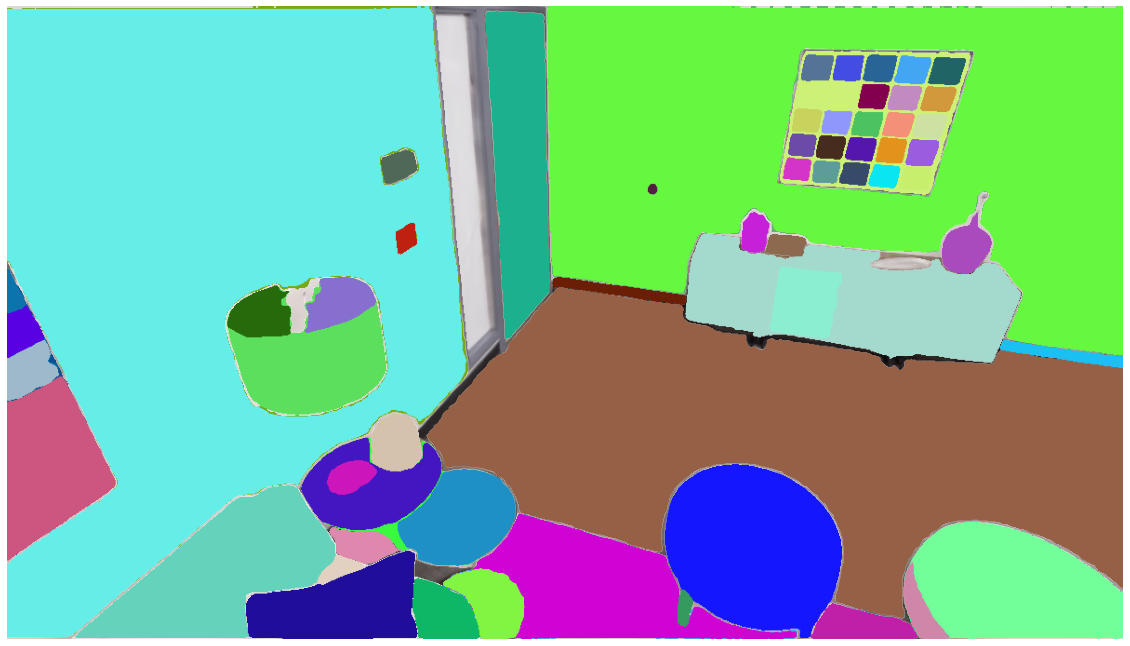

In [14]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
)
masks = mask_generator_2.generate(image)

#ids_curr,bbox=generateIdsNew(masks)
#ids_curr[ids_curr==-1]=-2
input_point = np.array([[500, 375]])
input_label = np.array([1])
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()


In [15]:

'''plt.figure(figsize=(10, 10))
plt.imshow(image)
show_box(bbox[0], plt.gca())
plt.axis('off')
plt.show()'''

"plt.figure(figsize=(10, 10))\nplt.imshow(image)\nshow_box(bbox[0], plt.gca())\nplt.axis('off')\nplt.show()"

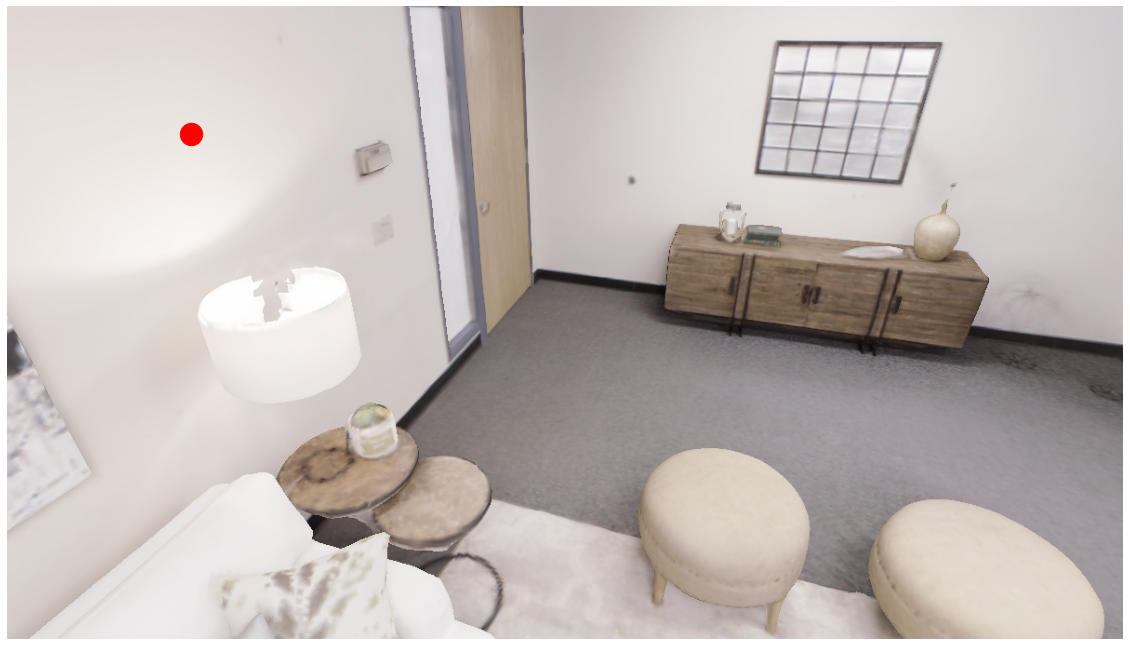

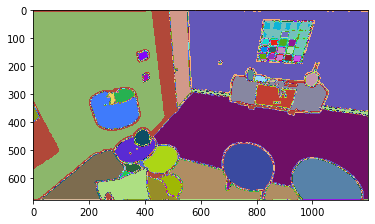

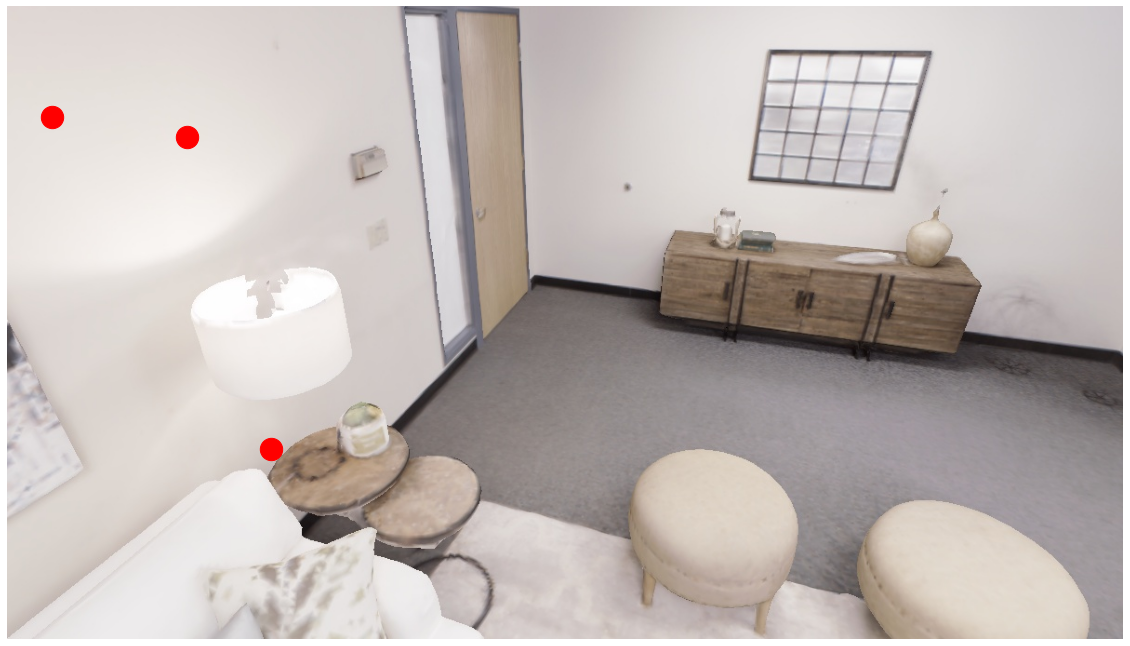

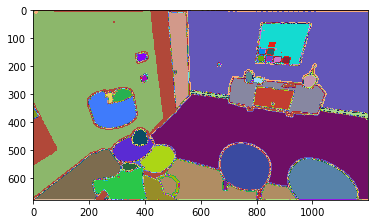

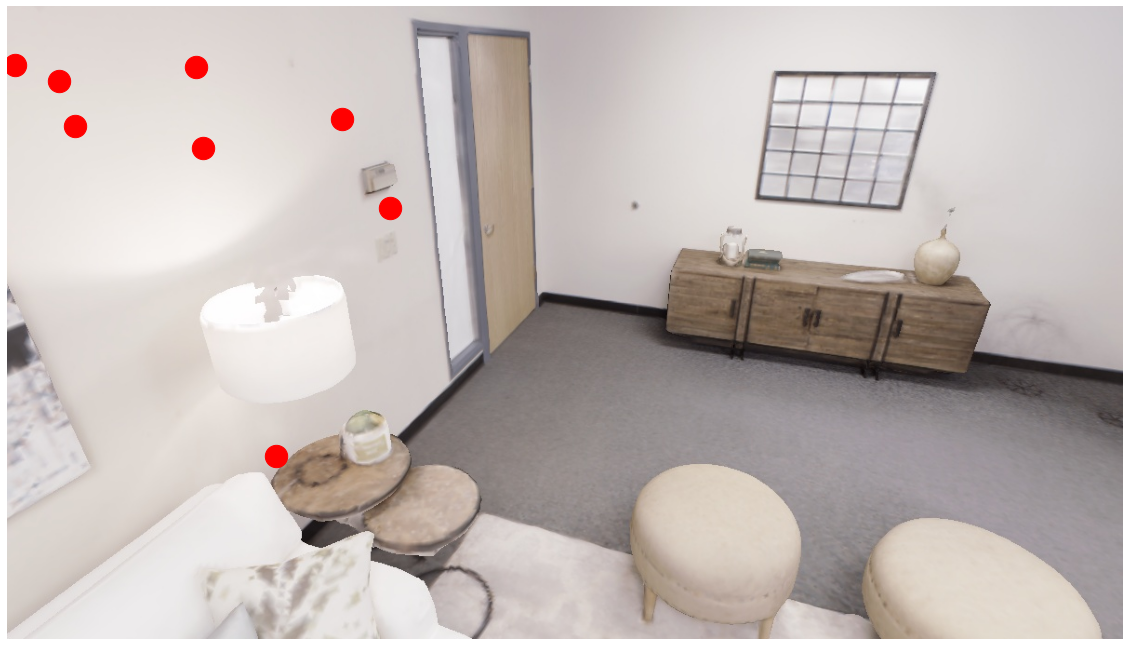

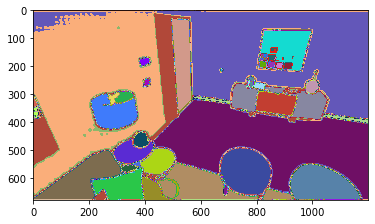

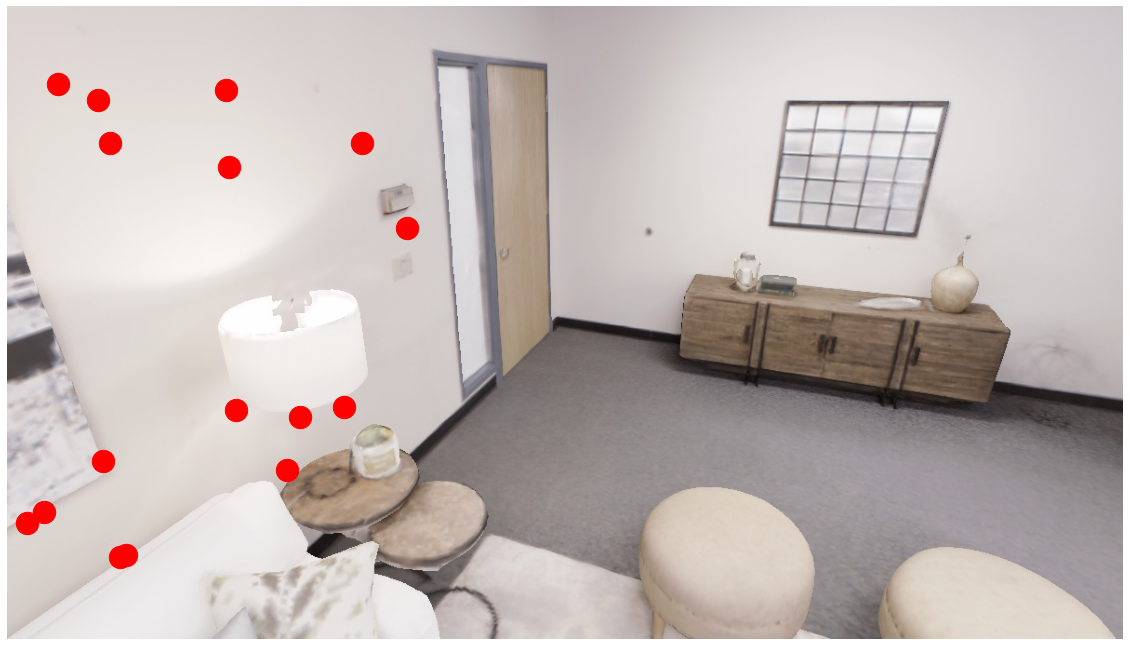

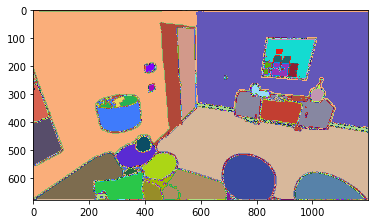

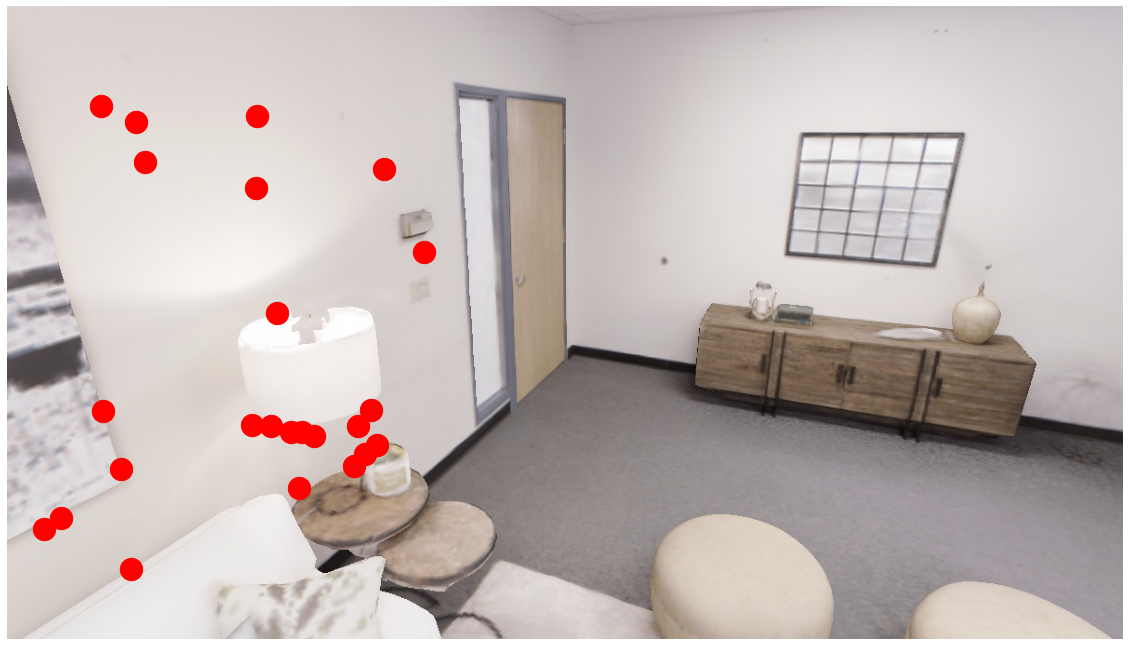

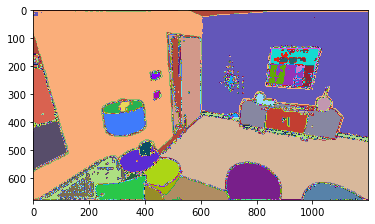

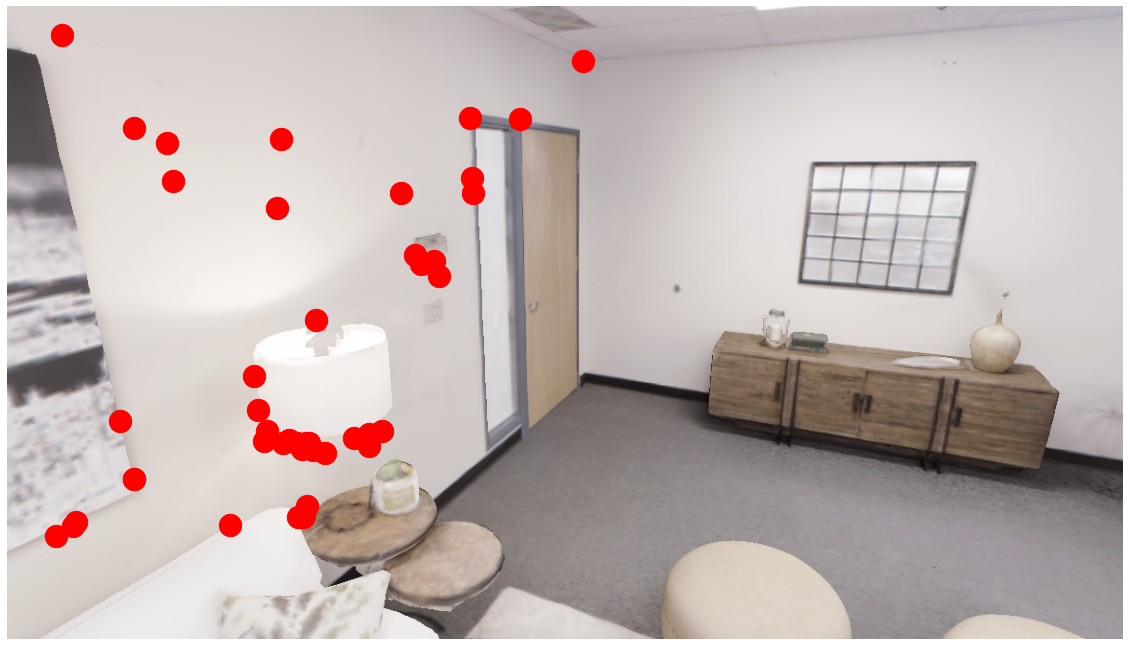

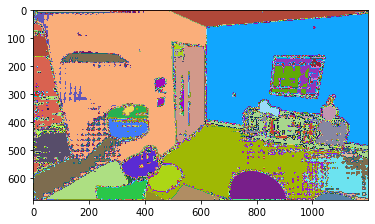

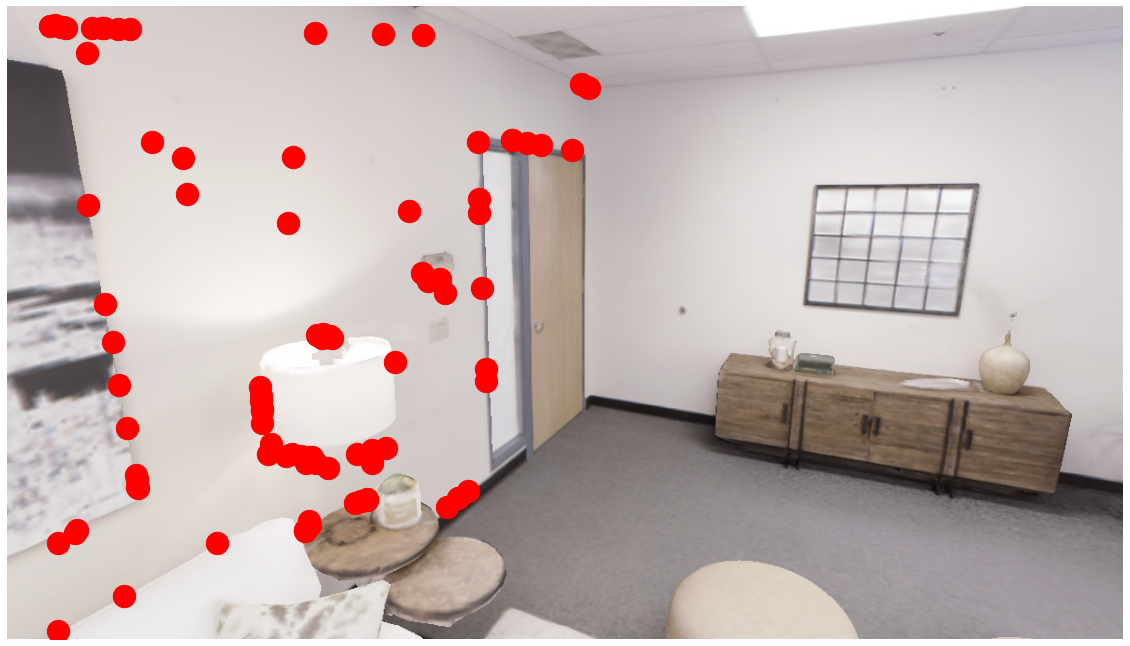

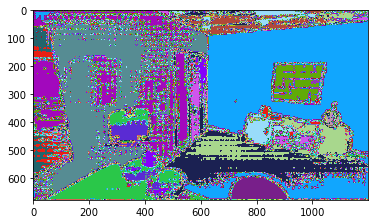

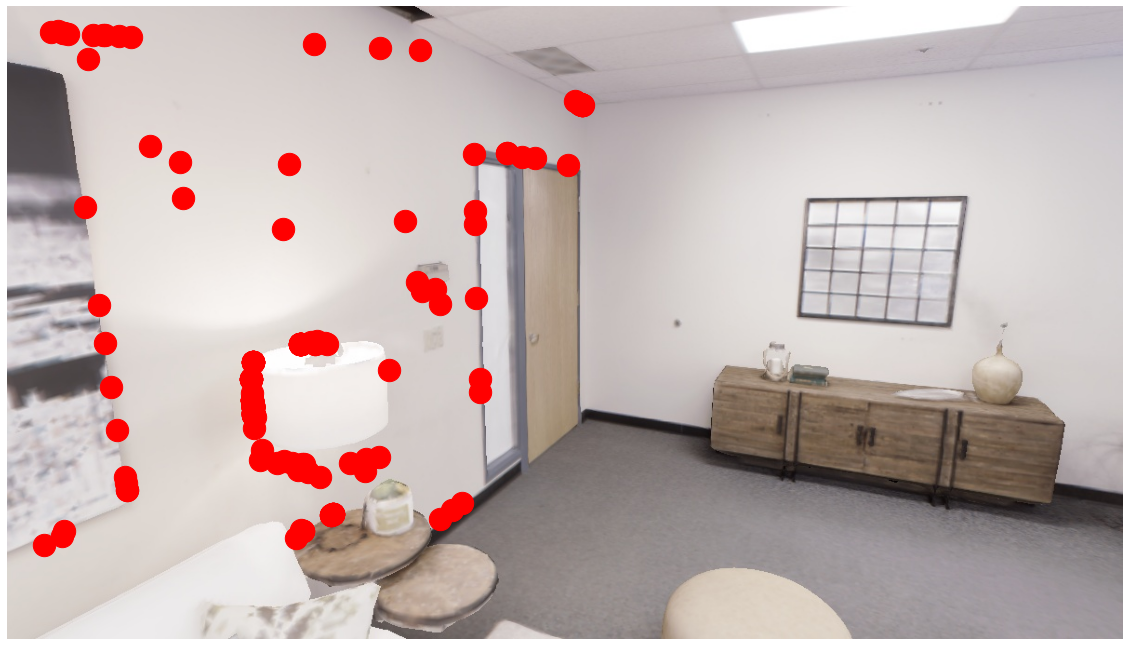

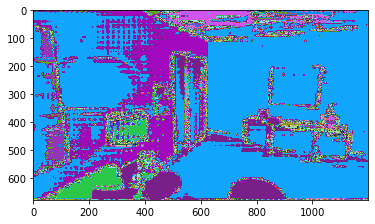

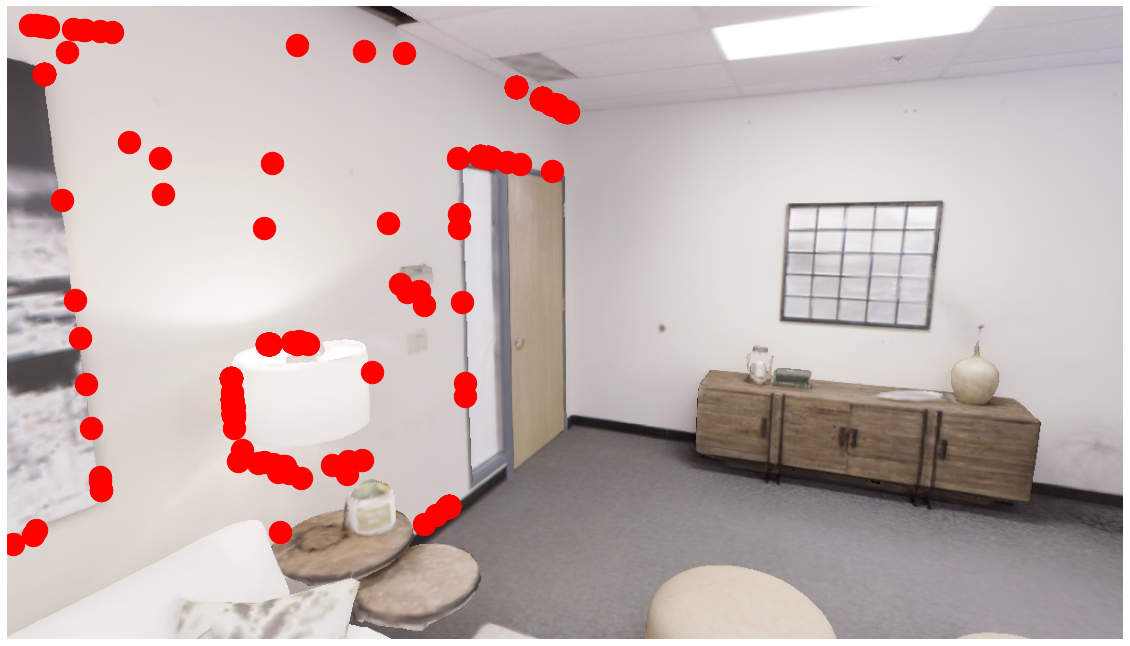

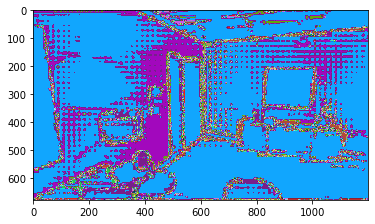

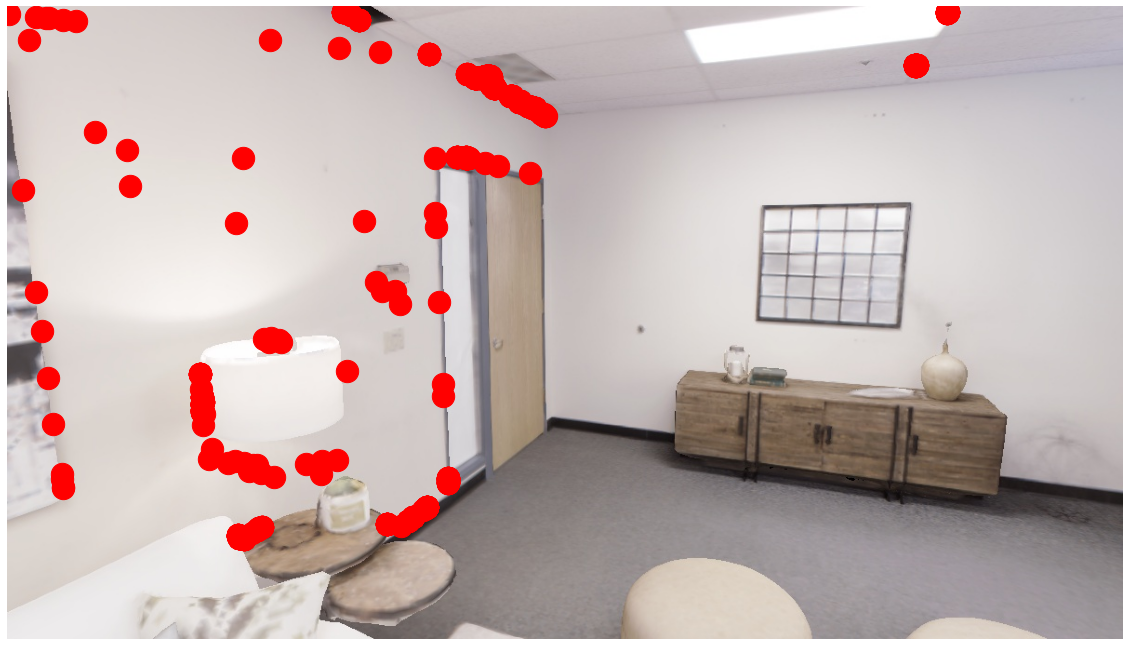

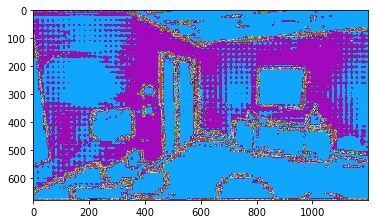

KeyboardInterrupt: 

In [16]:

#ä weighing

visualizerForId = visualizerForIds()
'''visualizerForId.visualizer(first)
visualizerForId.visualizer(ids_curr)
visualizerForId.visualizer(ids_curr)'''
depthf = readDepth(depth_paths[0])
frame_numbers = []
every_frame= 5
ppi = 2
segmentations = []
#segmentations.append(first)
id_counter = len(np.unique(first))
every_frame= 5
#print(sample_from_instances_with_ids(segmentations[0], len(np.unique(segmentations[0])), 5))
samples=None
ids_curr=generateIds(masks)
'''
for i in range(len(bbox)):
    uv = np.concatenate([np.array(bbox[i][:2]),np.array(bbox[i][2:])],axis=-1).astype(int)
    uv = uv.reshape(2, 2).T    
    bbox[i]=backproject.realWorldProject(uv, T_wc[0], K, depthf=depthf)

print("BBOX",bbox)  '''                                 
for i in range(0, 100, every_frame):
    '''
    print(f'At iteration {i}')
    print(int(i/every_frame))
    print(seg_paths[int(i/every_frame)])'''
    
    if(i==0):#
        #ids_curr = np.load(seg_paths[int(i/every_frame)])
        ids_curr=ids_curr
        segmentations.append(ids_curr)
        frame_numbers.append(i)
        unique_ids = np.unique(ids_curr).astype(int)
        samplesFromCurrent = sample_from_instances_with_ids(
            ids_curr, len(unique_ids), ppi
        )

        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2,:],T_wc[0], K, depthf=depthf
        )
        realWorldSamples = np.concatenate((realWorldSamples,samplesFromCurrent[2:,:]),axis=0)

        #if samples is None:
        samples=realWorldSamples
        ''' 
        else:
            samples=np.concatenate((samples,frontProjectedSamples),axis=1)'''
        continue
    # frame_paths read image
    #image=cv2.imread(frame_paths[i])
    imagNext=cv2.imread(frame_paths[i])
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imageNext = cv2.cvtColor(imagNext, cv2.COLOR_BGR2RGB)
    
    '''
    segmentationCurr = id_generation.createReverseMapping(ids_curr, i, frame_numbers, T_wc, K, depth_paths, segmentations, id_counter,predictor, points_per_instance = ppi, current_frame=imageNext)
    '''
    
    masksCreated,samples = id_generation.createReverseMappingCombined(i, T_wc, K, depth_paths, id_counter=id_counter,predictor=predictor, points_per_instance = ppi, current_frame=imageNext,samples=samples,bbox=None)
    #print(samples)
        
    segmentations.append(masksCreated)
    
    '''plt.figure(figsize=(10,10))
    plt.imshow(imageNext)
    show_mask(segmentationCurr, plt.gca())
    plt.axis('off')
    plt.show() '''
    visualizerForId.visualizer(masksCreated)
    #save output
    frame_numbers.append(i-5)
    ppi*=2
torch.cuda.empty_cache()


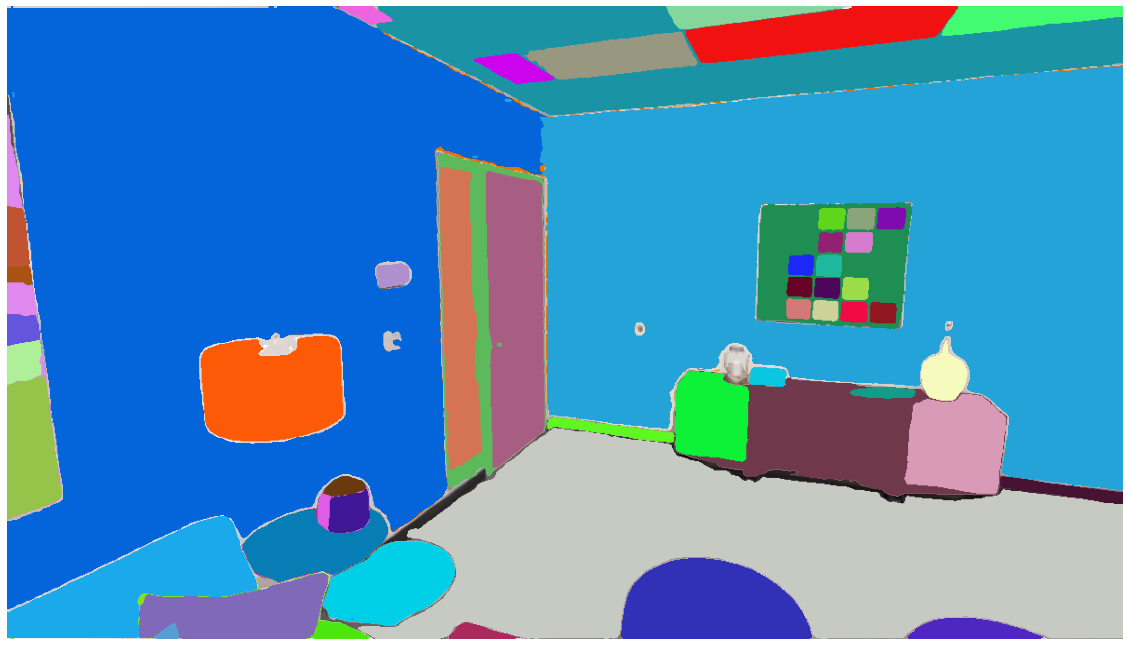

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()

In [ ]:

#ä weighing
for i in range(0, 50, every_frame):
    print(f'At iteration {i}')
    print(int(i/every_frame))
    print(seg_paths[int(i/every_frame)])
    if(i==0):
        ids_curr = np.load(seg_paths[int(i/every_frame)])
        segmentations.append(ids_curr)
        frame_numbers.append(i)
        continue
    ids_curr = np.load(seg_paths[int(i/every_frame)])
    map, id_counter = id_generation.create_complete_mapping_of_current_frame(ids_curr, i, frame_numbers, T_wc, K, depth_paths, segmentations, id_counter, points_per_instance = ppi)
    ids = id_generation.update_current_frame(ids_curr, map)
    segmentations.append(ids)
    #save output
    frame_numbers.append(i)
    print(f'Frame numbers: {frame_numbers}')
    
    


At iteration 0
0
/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic000000.npy
At iteration 5
1
/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic000005.npy
Frame numbers: [0, 0, 5]
At iteration 10
2
/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic000010.npy
Frame numbers: [0, 0, 5, 10]
At iteration 15
3
/home/koerner/Project/nice-slam/Datasets/generated/room0/results/semantic000015.npy


IndexError: list index out of range

In [ ]:
'''for segment in segmentations:
    plt.imshow(segment,cmap='plasma',interpolation='nearest')
    plt.show()'''

"for segment in segmentations:\n    plt.imshow(segment,cmap='plasma',interpolation='nearest')\n    plt.show()"

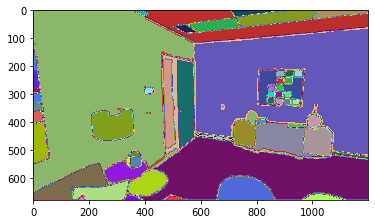

0


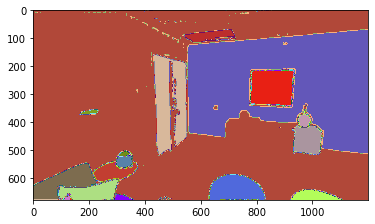

5


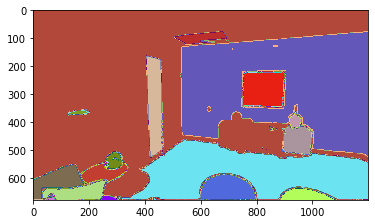

10


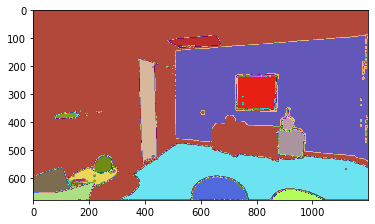

15


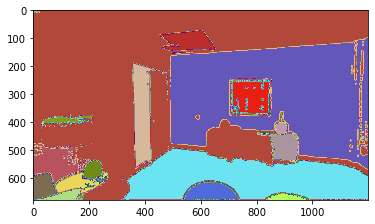

20


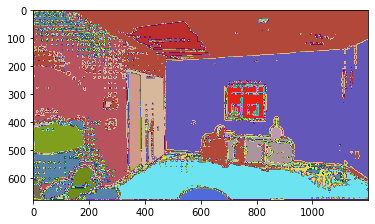

25


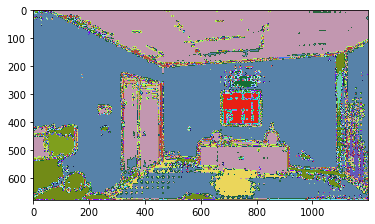

30


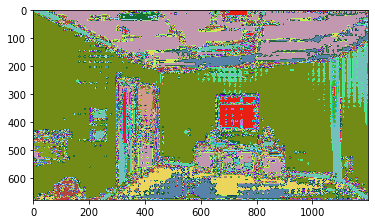

35


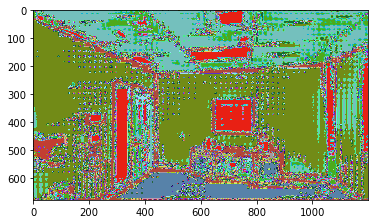

40


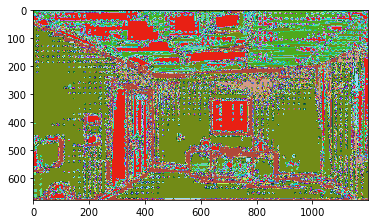

45


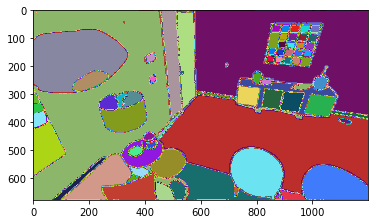

50


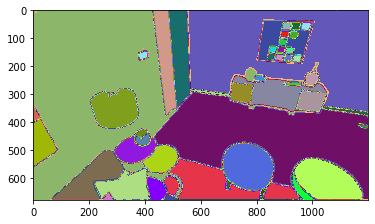

55


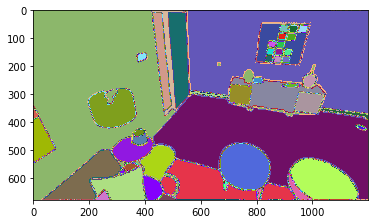

60


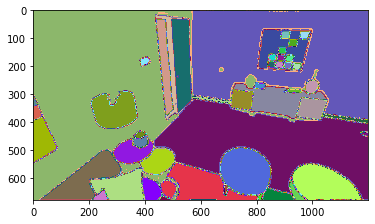

65


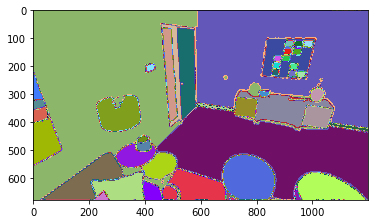

70


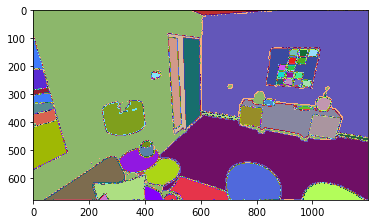

75


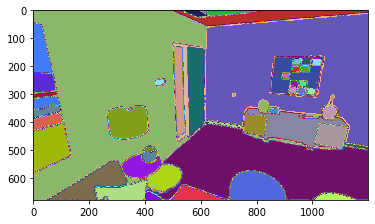

80


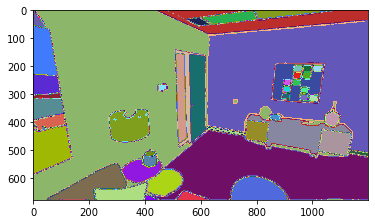

85


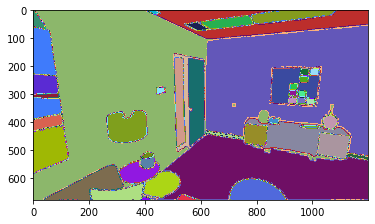

90


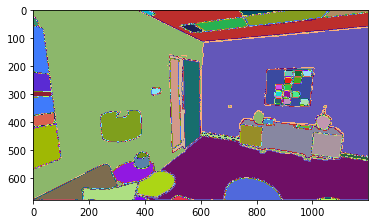

95
1338


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from vis import visualizerForIds

visualizerForId = visualizerForIds()
'''visualizerForId.visualizer(first)
visualizerForId.visualizer(ids_curr)
visualizerForId.visualizer(ids_curr)'''
cc=0
for segment in segmentations:
    visualizerForId.visualizer(segment)
    print(cc)
    cc+=5
'''visualizerForId.visualizer(ids)'''
print(np.max(segmentations[-1]))

In [ ]:
segmentations.append(ids)
#save output
frame_numbers.append(i)

In [ ]:
i = 10

ids_curr = np.load(seg_paths[int(i/every_frame)])
np.unique(ids_curr)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86], dtype=int32)

In [ ]:
map, id_counter = id_generation.create_complete_mapping_of_current_frame(ids_curr, i, frame_numbers, T_wc, K, depth_paths, segmentations, id_counter, points_per_instance = 1000)

KeyboardInterrupt: 

In [ ]:
ids = id_generation.update_current_frame(ids_curr, map)

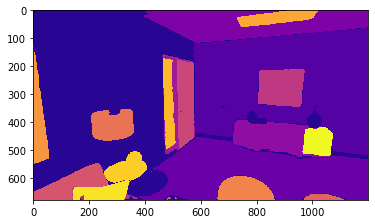

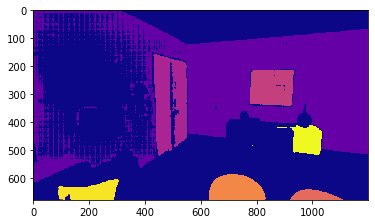

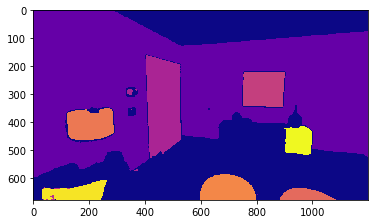

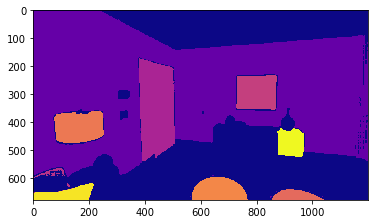

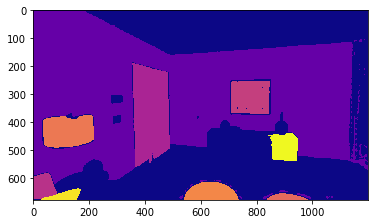

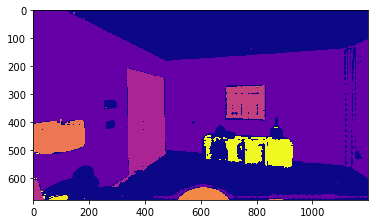

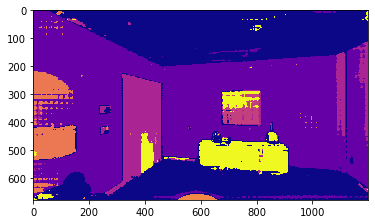

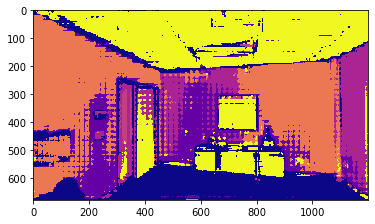

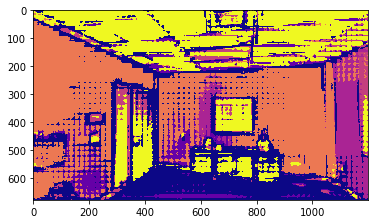

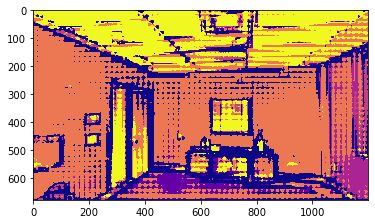

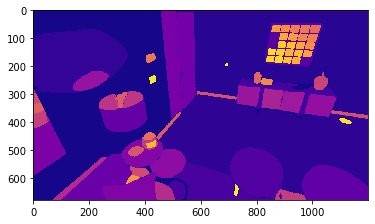

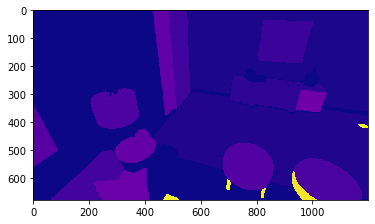

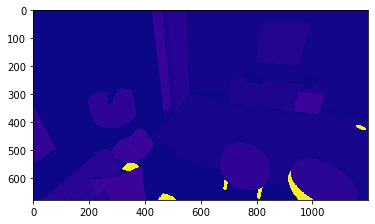

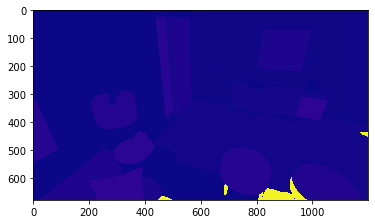

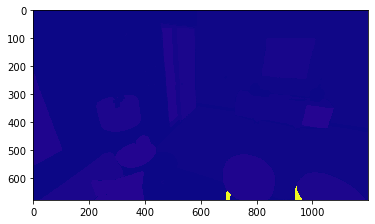

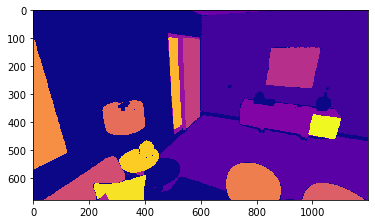

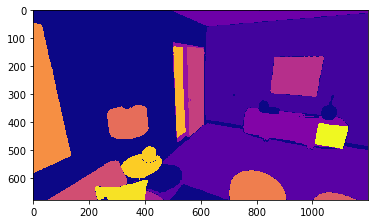

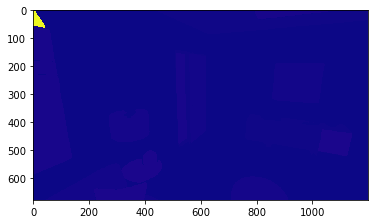

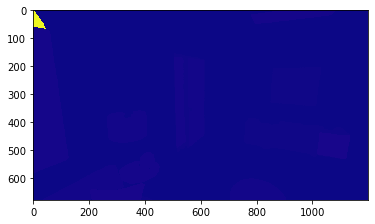

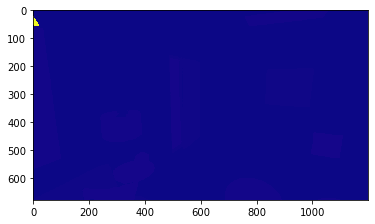

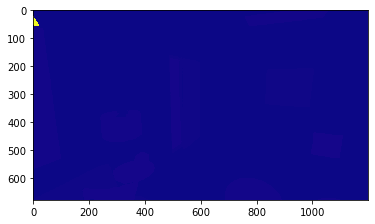

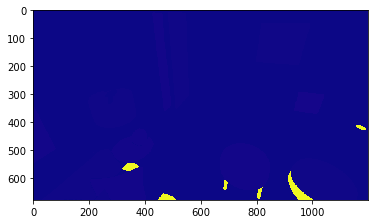

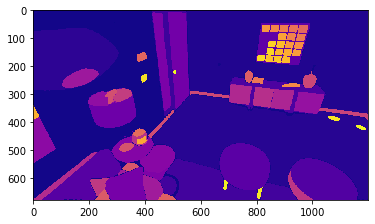

In [ ]:
for segment in segmentations:
    plt.imshow(segment,cmap='plasma',interpolation='nearest')
    plt.show()

plt.imshow(ids,cmap='plasma',interpolation='nearest')
plt.show()
plt.imshow(ids_curr,cmap='plasma',interpolation='nearest')

In [ ]:
segmentations[0][400,300],segmentations[1][420,300]

(13, -1)